In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
# import mkl

# mkl.set_num_threads(2)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def randn(*dims):
    return np.random.randn(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1) 
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)

def classify(mlp, batch):
    probabilities, _ = forward_pass(mlp, batch, False)
    return np.argmax(probabilities, axis=1)

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

def draw_layer_filters(layer):
    filters = np.reshape(layer.W[:-1].T, newshape=(16, -1, 28, 28))
    tiles(filters)

### Activation functions

In [3]:
def sigmoid(batch, stochastic=False):
    activations = 1.0 / (1.0 + np.exp(-batch))
    if stochastic:
        return activations > rand(*activations.shape).astype(np.float32)
    else:
        return activations

def sigmoid_derivative(batch):
    s = sigmoid(batch)
    return s * (1.0 - s)

def softmax(batch):
    norm_batch = batch - np.max(batch, axis=-1, keepdims=True)
    numerator = np.exp(norm_batch)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    return numerator / denominator

In [4]:
def relu(batch, stochastic=False):
    
    if stochastic:
        return np.maximum(0, batch + np.random.normal(scale=np.sqrt(sigmoid(batch)), size=batch.shape))
    else:
        return np.maximum(0, batch)

def relu_derivative(batch):
    return np.where(batch <= 0, 0, 1)

# MNIST dataset

In [5]:
!pip install mnist

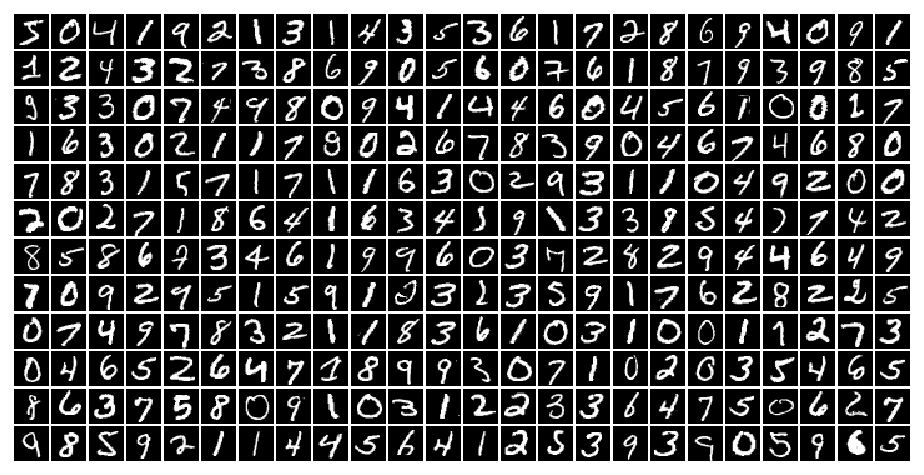

In [6]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# MLP training

In [7]:
class Layer:
    def __init__(self, visible_size, hidden_size, activation_fun, d_activation_fun, 
                 dropout_rate, learning_rate, momentum, weight_limit):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
        
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.weight_limit = weight_limit
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size)).astype(np.float32)
        self.W[-1, :] = 0.0
        
        self.activations = None
        self.d_activations = None
        self.deltas = None
        
        self.M = zeros(self.visible_size+1, self.hidden_size)
        
    def deep_copy(self):
        copy = Layer(self.visible_size, self.hidden_size, self.activation_fun, self.d_activation_fun,
                     self.dropout_rate, self.learning_rate, self.momentum, self.weight_limit)
        copy.W = np.copy(self.W)
        copy.M = np.copy(self.M)
        return copy

In [8]:
def limit_weights(weights, limit):
    limits = ones(*weights.shape)
    col_norms = np.linalg.norm(weights, axis=0)
    limits[:, col_norms > limit] = limit / col_norms[col_norms > limit]
    return weights * limits

### Forward pass

Calculate total input to the neurons. Then calculate activations (remember to add *ones* as the last column). Store result in `layer.activations`.

##### Computing derivatives of activation function

If `compute_derivatives` is set to `True`, we also need to compute the derivatives of the activation function and store them in `layer.d_activations`. We **do not** need to add *ones column* to the derivatives matrix! *Ones* are only needed in the activations matrix, where they are used to add biases to the total input of neurons in the next hidden layer.

##### Dropout

If `compute_derivatives` is set to `True` and the dropout rate in the input layer is greater than 0, we need to calculate the dropout mask for the MLP input and apply it to `batch`.

When calculating hidden activations in an MLP layer, check whether dropout rate in the next layer is greater then 0. If yes, then we need to apply dropout to the calculated activations (and derivatives of activations). In this case:
* construct dropout mask for the hidden layer,
* apply this mask to where it is needed in the hidden layer.

Do **not** apply dropout to the last column in activations or input batch, as they contains fixed *ones*.

In [9]:
def forward_pass(mlp, batch, compute_derivatives):    
    if compute_derivatives and mlp[0].dropout_rate > 0:
        batch = np.copy(batch)
        
        mask_shape = batch.shape[0], batch.shape[1] - 1
        dropout_mask = rand(*mask_shape) >= mlp[0].dropout_rate
        batch[:, :-1] *= dropout_mask
        
    visible = batch
    
    for layer_idx, layer in enumerate(mlp):
        z = visible @ layer.W
        layer.activations = append_ones(layer.activation_fun(z))
        
        if compute_derivatives and (layer_idx < len(mlp) - 1):
            layer.d_activations = layer.d_activation_fun(z)
            
            if mlp[layer_idx+1].dropout_rate > 0:
               
                mask_shape = layer.d_activations.shape[0], layer.d_activations.shape[1]
                dropout_mask = rand(*mask_shape) >= mlp[layer_idx+1].dropout_rate
                
                layer.activations[:, :-1] *= dropout_mask
                layer.d_activations *= dropout_mask
        
        visible = layer.activations
    
    return visible[:, :-1], batch

### Error backpropagation

In [10]:
def error_backpropagate(mlp, batch):
    observations_count = batch.shape[0]
    
    for layer_idx, layer in reversed(list(enumerate(mlp))):
        if layer_idx > 0:
            prev_layer = mlp[layer_idx - 1]
            visible = prev_layer.activations
            
            prev_layer.deltas = (layer.deltas @ layer.W[:-1].T) * prev_layer.d_activations
        else:
            visible = batch
        
        gradient = (visible.T @ layer.deltas) / observations_count        
        
        layer.M = layer.momentum * layer.M - layer.learning_rate * gradient
        layer.W += layer.M
        
        if layer.weight_limit > 0.0:
            layer.W[:-1, :] = limit_weights(layer.W[:-1, :], layer.weight_limit)

### Mean dropout network

Implement the weight scalling for the network that approximates MLP outputs under dropout.

In [11]:
def mean_network(mlp):
    mlp = [layer.deep_copy() for layer in mlp]
    
    for layer in mlp:
      
        layer.W[:-1, :] *= 1 - layer.dropout_rate
    
    return mlp

### Training procedure

In [12]:
def train_mlp(mlp, dataset, labels, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    
    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)
    
    for batch_idx, (batch, batch_labels) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        y, batch_with_dropout = forward_pass(mlp, batch, True)
        
        mlp[-1].deltas = y - batch_labels
        
        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, batch_with_dropout)
        
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

In [13]:
def run_mlp_training(mlp, train_set, train_labels, validation_set, validation_labels,
                     batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")
        
        if epoch == 5:
            for layer in mlp:
                layer.momentum = 0.95
                layer.learning_rate = 0.15
        elif epoch == 150:
            for layer in mlp:
                layer.momentum = 0.925
                layer.learning_rate = 0.1
        elif epoch == 175:
            for layer in mlp:
                layer.momentum = 0.9
                layer.learning_rate = 0.01
                
        start_time = time.time()
        train_mlp(mlp, train_set, train_labels, batch_size)
        elapsed = time.time() - start_time
        
        test_mlp = mean_network(mlp)
        
        predictions = classify(test_mlp, validation_set)
        accuracy = 100.0 * np.sum(predictions == validation_labels) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2f}".format(elapsed, accuracy))

    print("Training finished!")

# MNIST digits classification

In [14]:
DATASET_SIZE = 5000 # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(mnist_test_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))
mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

In [15]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 1024

BATCH_SIZE = 128
EPOCHS_COUNT = 200

LEARNING_RATE = 0.03
SOFTMAX_LEARNING_RATE = 0.15
MOMENTUM = 0.5

In [16]:
from IPython.core.display import HTML

def evaluate(mlp, train_set, train_labels,
             validation_set, validation_labels,
             batch_size, epochs_count):
    for layer in mlp:
        layer.reset()

    display(HTML('<h3>MLP training</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>Input layer filters in MLP</h3>'))
    draw_layer_filters(mlp[0])
    
    display(HTML('<h3>Largest norms of weight-vectors in MLP layers</h3>'))
    for i, layer in enumerate(mlp):
        max_norm = np.max(np.linalg.norm(layer.W[:-1, :], axis=0))
        print('\tlayer {0}: {1:.2f}'.format(i+1, max_norm))

### Plain MLP (no dropout)

Epoch 1:	########################################	elapsed: 3.06s, accuracy: 18.95
Epoch 2:	########################################	elapsed: 3.06s, accuracy: 46.62
Epoch 3:	########################################	elapsed: 3.08s, accuracy: 69.77
Epoch 4:	########################################	elapsed: 3.01s, accuracy: 75.62
Epoch 5:	########################################	elapsed: 3.03s, accuracy: 80.23
Epoch 6:	########################################	elapsed: 3.12s, accuracy: 87.88
Epoch 7:	########################################	elapsed: 2.99s, accuracy: 91.00
Epoch 8:	########################################	elapsed: 2.99s, accuracy: 92.48
Epoch 9:	########################################	elapsed: 2.98s, accuracy: 91.82
Epoch 10:	########################################	elapsed: 3.03s, accuracy: 90.37
Epoch 11:	########################################	elapsed: 2.99s, accuracy: 90.02
Epoch 12:	########################################	elapsed: 3.01s, accuracy: 92.58
Epoch 13:	###

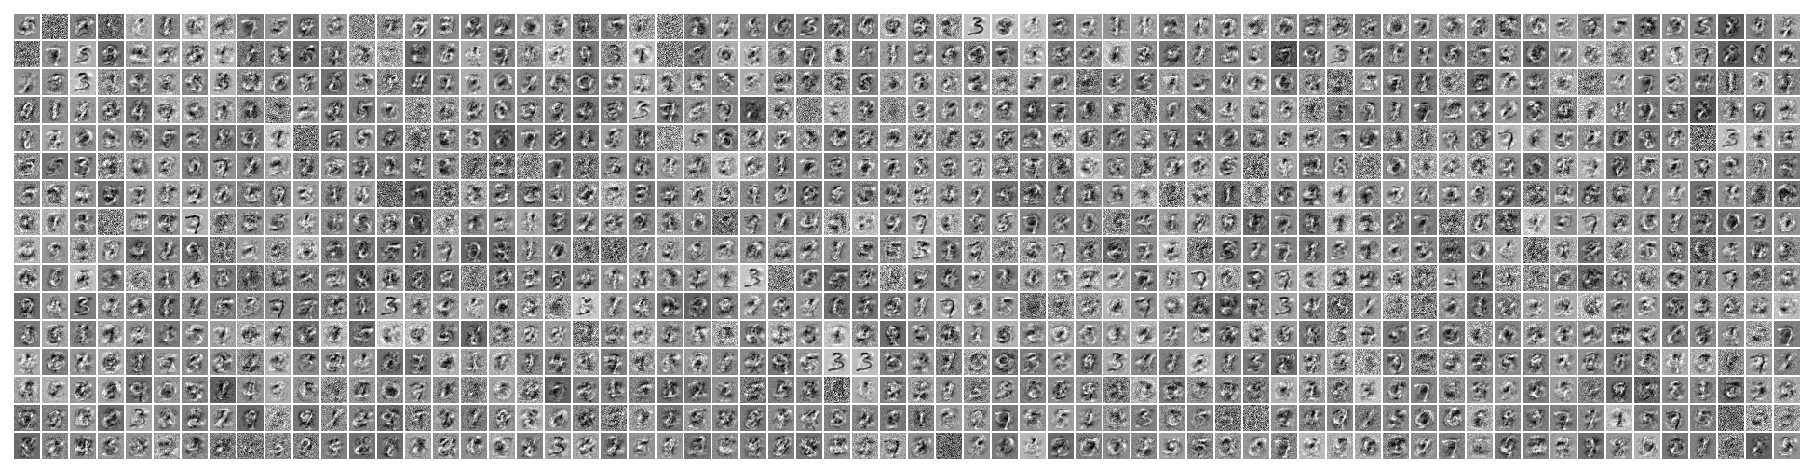

	layer 1: 2.00
	layer 2: 2.00
	layer 3: 2.50


In [17]:
mlp = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.0, LEARNING_RATE, MOMENTUM,
          weight_limit=2.0),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.0, LEARNING_RATE, MOMENTUM,
          weight_limit=2.0),
    Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, 0.0, SOFTMAX_LEARNING_RATE, MOMENTUM,
          weight_limit=2.5)
]

evaluate(mlp, 
         mnist_train_images, mnist_train_labels, 
         mnist_test_images, mnist_test_labels,
         BATCH_SIZE, EPOCHS_COUNT)

### MLP with dropout

Epoch 1:	########################################	elapsed: 3.42s, accuracy: 11.35
Epoch 2:	########################################	elapsed: 3.29s, accuracy: 11.35
Epoch 3:	########################################	elapsed: 3.33s, accuracy: 11.35
Epoch 4:	########################################	elapsed: 3.31s, accuracy: 11.35
Epoch 5:	########################################	elapsed: 3.35s, accuracy: 11.35
Epoch 6:	########################################	elapsed: 3.35s, accuracy: 49.43
Epoch 7:	########################################	elapsed: 3.48s, accuracy: 84.02
Epoch 8:	########################################	elapsed: 3.36s, accuracy: 88.13
Epoch 9:	########################################	elapsed: 3.40s, accuracy: 89.16
Epoch 10:	########################################	elapsed: 3.32s, accuracy: 91.96
Epoch 11:	########################################	elapsed: 3.42s, accuracy: 93.16
Epoch 12:	########################################	elapsed: 3.33s, accuracy: 93.22
Epoch 13:	###

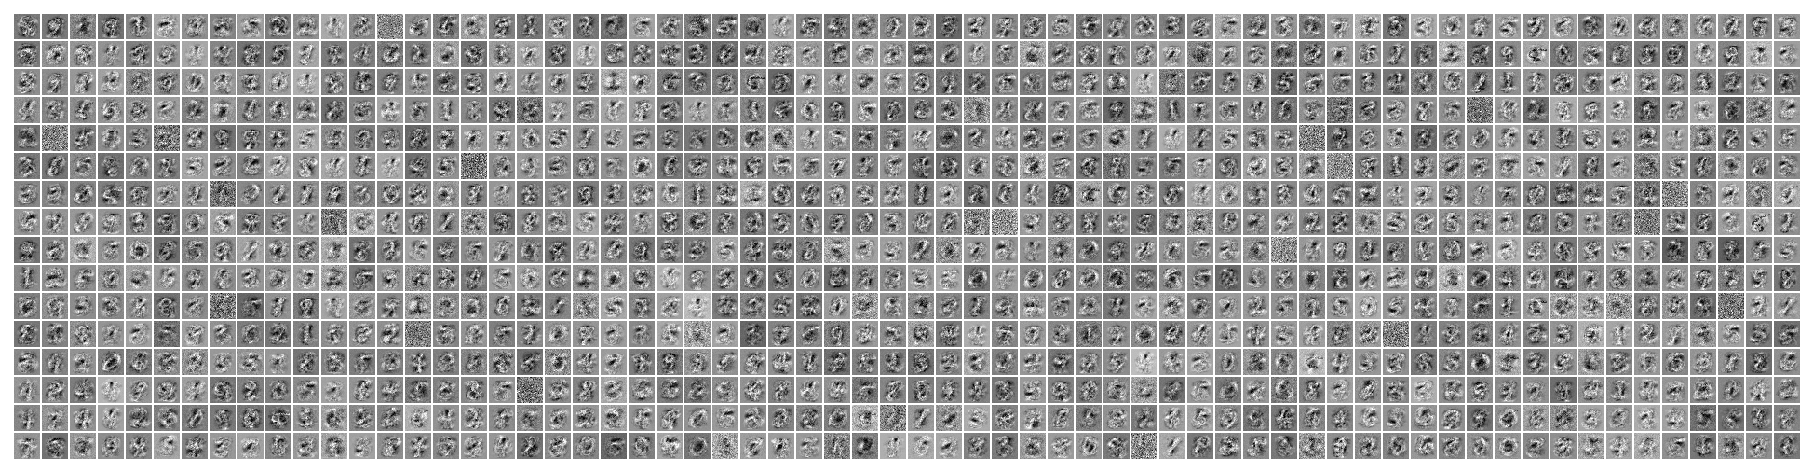

	layer 1: 2.00
	layer 2: 2.00
	layer 3: 2.50


In [18]:
mlp_with_dropout = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.2, LEARNING_RATE, MOMENTUM,
          weight_limit=2.0),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.5, LEARNING_RATE, MOMENTUM,
          weight_limit=2.0),
    Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, 0.5, SOFTMAX_LEARNING_RATE, MOMENTUM,
          weight_limit=2.5)
]

evaluate(mlp_with_dropout, 
         mnist_train_images, mnist_train_labels, 
         mnist_test_images, mnist_test_labels,
         BATCH_SIZE, EPOCHS_COUNT)

-20
